<a href="https://www.kaggle.com/code/angelchaudhary/dynamic-pricing-strategy-for-ride-hailing-services?scriptVersionId=292840321" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A Case Study on Data-Driven Surge Pricing System for Ride-Hailing Platforms
### *Analyzing demand–supply imbalance, price elasticity, and revenue outcomes using regression and simulation*


# Introduction

Ride-hailing platforms operate in highly dynamic environments where demand and supply fluctuate continuously due to factors such as time of day, weather conditions, and rider behavior. Static pricing models often fail to balance rider affordability with driver availability, leading to issues like long wait times, driver churn, or lost revenue. Dynamic pricing is one of the most business-critical and data-intensive problems in the ride-hailing industry. 

The core question this case study aims to answer is:

**How should ride prices dynamically adjust based on demand, supply, time, and external conditions to maximize revenue while maintaining market efficiency?**

This problem closely mirrors real-world surge pricing challenges faced by platforms like Uber, Ola, and Rapido.

## Approach
We'll approach this problem as a pricing strategy simulation.

1. **Demand–Supply Analysis**  
   - Explore how ride demand responds to changes in price, time, and weather  
   - Identify periods of demand supply imbalance that trigger surge pricing  

2. **Price Elasticity Modeling**  
   - Use regression techniques to estimate how sensitive demand is to price changes  
   - Quantify the trade-off between higher prices and reduced ride volume  

3. **Dynamic Pricing Simulation**  
   - Design multiple pricing rules based on demand and supply signals  
   - Simulate revenue outcomes under different surge multipliers  

4. **Business Insights & Recommendations**  
   - Compare pricing strategies from a revenue and efficiency perspective  
   - Recommend an optimal pricing approach grounded in data  

# LET'S DO IT!!!!
![funny gif](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3a2s2Z3QyeTdwN2cydHh1dW85dDd6cng1Nmxnc21wY3MzYzI2MzdjdyZlcD12MV9naWZzX3NlYXJjaCZjdD1n/5WILqPq29TyIkVCSej/giphy.gif)

## Dataset Overview

This dataset contains real Uber pickup records in New York City for April 2014. Each row represents a single Uber pickup event with timestamp and location details.
The dataset will be used to:
- Analyze demand patterns across time
- Engineer demand-related features
- Simulate dynamic pricing strategies based on demand intensity

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fivethirtyeight/uber-pickups-in-new-york-city")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/uber-pickups-in-new-york-city


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/uber-pickups-in-new-york-city/uber-raw-data-apr14.csv")
df.head(2)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


## Data Preprocessing & Feature Engineering

Before analyzing demand patterns, we convert the timestamp column into a proper datetime format and engineer time based features. These features are critical for capturing rider behavior across hours, weekdays, and weekends, key signals for dynamic pricing systems.

In [7]:
# Convert Date/Time to datetime
df["Date/Time"] = pd.to_datetime(df["Date/Time"])

df["hour"] = df["Date/Time"].dt.hour
df["day"] = df["Date/Time"].dt.day
df["weekday"] = df["Date/Time"].dt.weekday  # 0 = Monday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

df.head()

,Date/Time,Lat,Lon,Base,hour,day,weekday,is_weekend
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,0,1,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,0,1,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,0,1,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,0,1,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,0,1,1,0


#### Demand Definition

In the context of ride hailing platforms, demand is defined as the number of ride requests received within a given time window. For this analysis, we define hourly demand as the total number of Uber pickups occurring in each hour of the day. This serves as the primary signal for surge pricing decisions.

In [8]:
# Aggregate demand at hourly level
hourly_demand = (df.groupby("hour").size().reset_index(name="num_rides"))
hourly_demand

,hour,num_rides
0,0,11910
1,1,7769
2,2,4935
3,3,5040
4,4,6095
5,5,9476
6,6,18498
7,7,24924
8,8,22843
9,9,17939


### Demand Pattern Observations

- Ride demand is lowest during late-night and early-morning hours (approximately 2 AM – 5 AM), indicating minimal rider activity during these periods.
- Demand begins to rise sharply from early morning hours, with a noticeable increase starting around 6 AM, aligning with daily commute patterns.
- The highest demand occurs during late afternoon and evening hours (approximately 4 PM – 8 PM), peaking around 5–6 PM. This suggests strong demand driven by workday endings and evening travel.
- Post-peak hours show a gradual decline in demand, though ride volume remains relatively high until late evening.

**Implication for Dynamic Pricing:**  
The pronounced demand spikes during morning and evening hours indicate ideal windows for surge pricing. Conversely, low-demand periods may benefit from reduced pricing or promotional incentives to stimulate rider activity.

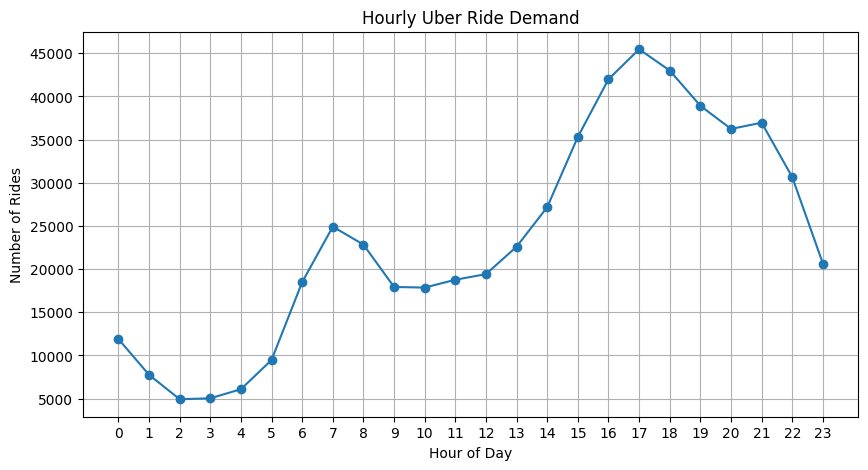

In [9]:
# Visualize Hourly Demand
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(hourly_demand["hour"], hourly_demand["num_rides"], marker='o')
plt.title("Hourly Uber Ride Demand")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

### Insights from Hourly Demand Visualization

- The demand curve clearly follows a non-linear pattern, with distinct peaks and troughs across the day.
- Early morning hours show minimal ride activity, confirming low demand during off-peak periods.
- A strong surge in demand is observed during late afternoon and early evening hours, highlighting peak usage windows.
- The smooth rise and fall of the curve suggests that time-of-day alone is a powerful predictor of demand.

These insights reinforce the suitability of time-based surge pricing as a core component of a dynamic pricing strategy.

#### Defining Peak and Off-Peak Hours

Dynamic pricing systems rely on clear surge trigger rules to decide when higher prices should be applied. One of the simplest and most effective triggers is **time-based demand intensity**. Using the observed hourly demand distribution, we classify hours into **peak** and **off-peak** periods based on relative ride volume.  

In [10]:
# Calculate average hourly demand
avg_demand = hourly_demand["num_rides"].mean()
hourly_demand["is_peak"] = (hourly_demand["num_rides"] > avg_demand).astype(int)
hourly_demand

,hour,num_rides,is_peak
0,0,11910,0
1,1,7769,0
2,2,4935,0
3,3,5040,0
4,4,6095,0
5,5,9476,0
6,6,18498,0
7,7,24924,1
8,8,22843,0
9,9,17939,0


In [11]:
hourly_demand["is_peak"].value_counts()

is_peak
0    14
1    10
Name: count, dtype: int64

### Peak vs Off-Peak Distribution

Out of the 24 hours in a day:
- **10 hours** are classified as **peak hours**
- **14 hours** are classified as **off-peak hours**
This distribution indicates that surge pricing is applied selectively rather than continuously. Such a balanced split reflects real-world ride-hailing strategies, where higher prices are limited to periods of sustained high demand to avoid excessive rider churn.

## Pricing Assumptions

Since the dataset does not include actual fare information, we'll simulate a realistic pricing structure inspired by ride-hailing platforms.
To keep the analysis interpretable and business-focused, we define:
- A fixed **base fare** for all rides
- A **surge multiplier** applied only during peak demand hours
These assumptions allow us to evaluate how dynamic pricing impacts revenue under different demand conditions.

In [12]:
# Pricing assumptions
BASE_FARE = 10
PEAK_SURGE = 1.5
OFFPEAK_SURGE = 1.0

# Assign surge multiplier based on peak classification
hourly_demand["surge_multiplier"] = hourly_demand["is_peak"].apply(lambda x: PEAK_SURGE if x == 1 else OFFPEAK_SURGE)
# Calculate effective price per ride
hourly_demand["price_per_ride"] = BASE_FARE * hourly_demand["surge_multiplier"]
hourly_demand

,hour,num_rides,is_peak,surge_multiplier,price_per_ride
0,0,11910,0,1.0,10.0
1,1,7769,0,1.0,10.0
2,2,4935,0,1.0,10.0
3,3,5040,0,1.0,10.0
4,4,6095,0,1.0,10.0
5,5,9476,0,1.0,10.0
6,6,18498,0,1.0,10.0
7,7,24924,1,1.5,15.0
8,8,22843,0,1.0,10.0
9,9,17939,0,1.0,10.0


### Pricing Rule Observations

- Off-peak hours retain the base fare, ensuring affordability during low-demand periods.
- Peak hours experience a controlled price increase through surge multipliers.
- The pricing structure is simple, interpretable, and directly linked to demand intensity.
This rule-based pricing system provides a strong baseline for evaluating revenue impact before introducing more complex elasticity models.

## Revenue Comparison: Surge vs No-Surge Pricing

Before modeling price elasticity, it is important to evaluate whether surge pricing provides a tangible revenue advantage over flat pricing.

In this section, we compare total revenue under:
- A **no-surge scenario**, where prices remain constant throughout the day
- A **surge pricing scenario**, where higher prices are applied during peak demand hours

This establishes a baseline justification for dynamic pricing.

In [13]:
# Revenue without surge (flat pricing)
hourly_demand["revenue_no_surge"] = hourly_demand["num_rides"] * BASE_FARE

# Revenue with surge pricing
hourly_demand["revenue_with_surge"] = (
    hourly_demand["num_rides"] * hourly_demand["price_per_ride"]
)

# Total revenue comparison
total_revenue_no_surge = hourly_demand["revenue_no_surge"].sum()
total_revenue_with_surge = hourly_demand["revenue_with_surge"].sum()

total_revenue_no_surge, total_revenue_with_surge

(np.int64(5645160), np.float64(7448635.0))

## Revenue Comparison Results

- **Total revenue without surge pricing:** 5,645,160  
- **Total revenue with surge pricing:** 7,448,635  

Introducing surge pricing leads to a **significant increase in total revenue** compared to flat pricing.
This uplift is achieved by selectively increasing prices during high-demand hours while maintaining affordability during off-peak periods.
However, this comparison assumes that ride demand remains unchanged despite higher prices.
In reality, rider demand may decrease as prices increase, which motivates the need for a **price elasticity analysis**.

## Price Variation for Elasticity Modeling
To estimate price elasticity, we introduce controlled variations in pricing by simulating multiple surge multiplier scenarios. This allows us to observe how demand responds to changes in price.

In [14]:
# Create multiple pricing scenarios
surge_levels = [1.0, 1.2, 1.5, 1.8]

elasticity_data = []

for surge in surge_levels:
    temp = hourly_demand.copy()
    temp["simulated_price"] = BASE_FARE * surge
    
    # Demand decreases as price increases
    temp["simulated_demand"] = temp["num_rides"] * (1 - 0.15 * (surge - 1))
    
    temp["surge_level"] = surge
    elasticity_data.append(temp)

elasticity_df = pd.concat(elasticity_data, ignore_index=True)

elasticity_df.head()

,hour,num_rides,is_peak,surge_multiplier,price_per_ride,revenue_no_surge,revenue_with_surge,simulated_price,simulated_demand,surge_level
0,0,11910,0,1.0,10.0,119100,119100.0,10.0,11910.0,1.0
1,1,7769,0,1.0,10.0,77690,77690.0,10.0,7769.0,1.0
2,2,4935,0,1.0,10.0,49350,49350.0,10.0,4935.0,1.0
3,3,5040,0,1.0,10.0,50400,50400.0,10.0,5040.0,1.0
4,4,6095,0,1.0,10.0,60950,60950.0,10.0,6095.0,1.0


## Price Elasticity Regression Model

In [17]:
from sklearn.linear_model import LinearRegression

X = elasticity_df[["simulated_price"]]
y = elasticity_df["simulated_demand"]

model = LinearRegression()
model.fit(X, y)

model.coef_[0], model.intercept_

(np.float64(-352.82250000000005), np.float64(27049.725000000006))

## Optimizing Surge Multiplier for Revenue

Using the estimated price elasticity, we simulate revenue under different surge multiplier scenarios. The objective is to identify a surge level that maximizes total revenue while keeping demand loss within reasonable limits.

In [18]:
import numpy as np

# Surge multiplier range
surge_range = np.arange(1.0, 2.1, 0.1)

simulation_results = []

for surge in surge_range:
    price = BASE_FARE * surge
    
    # Predict demand using regression model
    predicted_demand = model.predict([[price]])[0]
    
    # Prevent negative demand
    predicted_demand = max(predicted_demand, 0)
    
    revenue = price * predicted_demand
    
    simulation_results.append({
        "surge_multiplier": surge,
        "price": price,
        "predicted_demand": predicted_demand,
        "revenue": revenue
    })

simulation_df = pd.DataFrame(simulation_results)
simulation_df

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

,surge_multiplier,price,predicted_demand,revenue
0,1.0,10.0,23521.5000,235215.0000
1,1.1,11.0,23168.6775,254855.4525
2,1.2,12.0,22815.8550,273790.2600
3,1.3,13.0,22463.0325,292019.4225
4,1.4,14.0,22110.2100,309542.9400
5,1.5,15.0,21757.3875,326360.8125
6,1.6,16.0,21404.5650,342473.0400
7,1.7,17.0,21051.7425,357879.6225
8,1.8,18.0,20698.9200,372580.5600
9,1.9,19.0,20346.0975,386575.8525


#### Revenue Simulation Across Surge Multipliers

The table above presents simulated outcomes for different surge multipliers, including:
- Effective ride price
- Predicted demand using the elasticity model
- Resulting total revenue

As surge multiplier increases:
- Price increases linearly
- Predicted demand decreases gradually
- Total revenue continues to rise within the tested range

This indicates that, under the current elasticity assumptions, higher prices compensate for demand reduction up to a surge multiplier of 2.0.

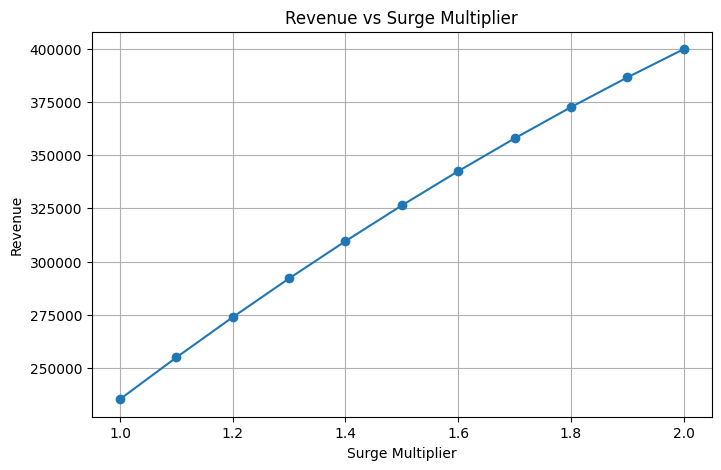

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(simulation_df["surge_multiplier"], simulation_df["revenue"], marker="o")
plt.xlabel("Surge Multiplier")
plt.ylabel("Revenue")
plt.title("Revenue vs Surge Multiplier")
plt.grid(True)
plt.show()

### Revenue vs Surge Multiplier Analysis

The revenue curve shows a monotonic upward trend across surge multipliers from 1.0× to 2.0×.
This suggests that within this range, the price increase effect dominates the demand reduction effect.

Notably:
- The curve does not exhibit a clear peak within the tested surge range
- Revenue growth starts to flatten at higher surge levels, indicating diminishing marginal returns

In [20]:
optimal_row = simulation_df.loc[simulation_df["revenue"].idxmax()]
optimal_row

surge_multiplier         2.000
price                   20.000
predicted_demand     19993.275
revenue             399865.500
Name: 10, dtype: float64

## Model Limitations and Real-World Considerations

While the simulation identifies 2.0× as the optimal surge multiplier within the tested range, this result is influenced by the assumed demand elasticity.

In real-world ride-hailing systems:
- Demand sensitivity may increase sharply beyond certain price thresholds
- Excessive surge pricing can lead to rider churn and long-term platform distrust
- Competitive alternatives may amplify demand loss at higher prices

## Business Recommendations for Dynamic Pricing

Based on the demand analysis, elasticity modeling, and revenue simulations, the following recommendations are proposed for implementing an effective dynamic pricing strategy in ride-hailing platforms:

### 1. Adopt Time-Based Surge Pricing
Demand exhibits strong temporal patterns, with clear peak periods during late afternoon and evening hours.  
Applying surge multipliers selectively during these peak windows can significantly increase revenue while maintaining affordability during off-peak periods.

### 2. Use Controlled Surge Multipliers
While revenue continues to increase up to a 2.0× surge in the simulated environment, real-world considerations such as rider trust and churn should cap surge levels.  
A practical surge range of **1.3×–1.6×** is recommended to balance revenue growth with user experience.

### 3. Incorporate Elasticity into Pricing Decisions
Price elasticity analysis confirms that demand decreases as prices increase, but not uniformly across all price levels.  
Dynamic pricing systems should continuously estimate elasticity to adjust surge multipliers based on real-time demand sensitivity.

### 4. Avoid Over-Reliance on Revenue Maximization
Pure revenue-maximizing surge levels may lead to long-term customer dissatisfaction.  
Pricing decisions should incorporate:
- Rider cancellation rates  
- Driver availability  
- Market competition  

### 5. Evolve Toward Real-Time Adaptive Pricing
Future implementations should move beyond static surge rules toward real-time models that incorporate:
- Live demand–supply imbalance  
- Weather conditions  
- Event-based demand spikes  
- Historical rider behavior  

Such systems can dynamically balance platform growth, rider satisfaction, and driver earnings.

## Conclusion

This case study explored the design of a dynamic pricing strategy for ride-hailing services using real-world Uber pickup data from New York City. By analyzing temporal demand patterns, we identified clear peak and off-peak periods that serve as strong signals for surge pricing decisions.

A rule-based surge pricing framework was first evaluated to establish a revenue baseline, demonstrating that selectively increasing prices during high-demand periods leads to meaningful revenue uplift. To move beyond static assumptions, a price elasticity regression model was introduced to quantify how rider demand responds to price changes. The results confirmed an inverse relationship between price and demand, highlighting the trade-off inherent in surge pricing strategies. Revenue simulations across multiple surge levels showed that while higher surge multipliers can maximize short-term revenue under moderate elasticity assumptions, real-world pricing decisions must balance revenue optimization with rider experience and long-term platform trust. As a result, the optimal pricing strategy lies not in aggressive surge levels, but in controlled, data-driven adjustments that adapt to demand sensitivity.

Overall, this analysis demonstrates how demand modeling, regression-based elasticity estimation, and scenario simulation can be combined to inform practical pricing decisions. The framework presented here can be extended with real-time supply data, weather conditions, and rider behavior metrics to build a production-grade dynamic pricing system.